In [ ]:
Adaboost算法函数说明
AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)
base_estimator：用于指定提升算法所应用的基础分类器，默认为分类决策树（CART），
                也可以是其他基础分类器，但分类器必须支持带样本权重的学习，如神经网络。
n_estimators：用于指定基础分类器的数量，默认为50个，
              当模型在训练数据集中得到完美的拟合后，可以提前结束算法，不一定非得构建完指定个数的基础分类器。
learning_rate：用于指定模型迭代的学习率或步长，即对应的提升模型F(x)可以表示为F(x)=Fm-1(x)+vamfm(x)，其中的v就是该参数的指定值，默认为1；
               对于较小的学习率v而言，则需要迭代更多次的基础分类器，通常情况下需要利用交叉验证法确定合理的基础分类器个数和学习率。
algorithm：用于指定AdaBoostClassifier分类器的算法，默认为'SAMME.R'，也可以使用'SAMME'；
           使用'SAMME.R'时，基础模型必须能够计算类别的概率值；
           一般而言，'SAMME.R'算法相比于'SAMME'算法，收敛更快、误差更小、迭代数量更少。
loss：用于指定AdaBoostRegressor回归提升树的损失函数，可以是'linear'，表示使用线性损失函数；
      也可以是'square'，表示使用平方损失函数；
      还可以是'exponential'，表示使用指数损失函数；
      该参数的默认值为'linear'。
random_state：用于指定随机数生成器的种子。

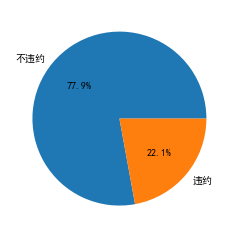

In [6]:
# 导入第三方包
import pandas as pd
import matplotlib.pyplot as plt

# 读入数据
default = pd.read_excel(r'default of credit card.xls')

# 数据集中是否违约的客户比例
# 为确保绘制的饼图为圆形，需执行如下代码
plt.axes(aspect = 'equal')
# 中文乱码和坐标轴负号的处理
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 统计客户是否违约的频数
counts = default.y.value_counts()
# 绘制饼图
plt.pie(x=counts, # 绘图数据
        labels=pd.Series(counts.index).map({0:'不违约',1:'违约'}),   # 添加文字标签
        autopct='%.1f%%')   # 设置百分比的格式，这里保留一位小数 
# 显示图形
plt.show()

In [10]:
# 将数据集拆分为训练集和测试集
# 导入第三方包
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

# 排除数据集中的ID变量和因变量，剩余的数据用作自变量X
X = default.drop(['ID', 'y'], axis=1)
y = default.y
# 数据拆分
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1234)

# 构建AdaBoost算法的类
AdaBoost1 = ensemble.AdaBoostClassifier()
# 算法在训练数据集上的拟合
AdaBoost1.fit(X_train,y_train)
# 算法在测试数据集上的预测
pred1 = AdaBoost1.predict(X_test)

# 返回模型的预测效果
print('模型的准确率为：\n', metrics.accuracy_score(y_test, pred1))
print('模型的评估报告：\n', metrics.classification_report(y_test, pred1))

模型的准确率为：
 0.8125333333333333
模型的评估报告：
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      5800
           1       0.68      0.32      0.44      1700

    accuracy                           0.81      7500
   macro avg       0.75      0.64      0.66      7500
weighted avg       0.80      0.81      0.79      7500



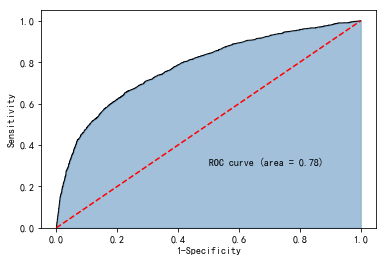

In [4]:
# 计算客户违约的概率值，用于生成ROC曲线的数据
y_score = AdaBoost1.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr, tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw=1)
# 添加对角线
plt.plot([0,1], [0,1], color='red', linestyle='--')
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

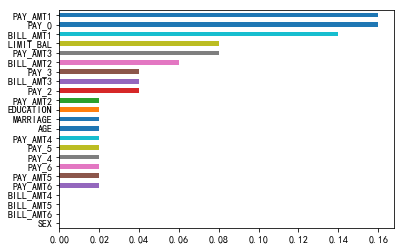

In [5]:
# 自变量的重要性排序
importance = pd.Series(AdaBoost1.feature_importances_, index=X.columns)
importance.sort_values().plot(kind='barh')
plt.show()

In [6]:
# 取出重要性比较高的自变量建模
predictors = list(importance[importance>0.02].index)
predictors

# 通过网格搜索法选择基础模型所对应的合理参数组合
# 导入第三方包
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

max_depth = [3, 4, 5, 6]
params1 = {'base_estimator__max_depth':max_depth}
base_model = GridSearchCV(estimator=ensemble.AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 
                          param_grid=params1, scoring='roc_auc', cv=5, n_jobs=4, verbose=1)
base_model.fit(X_train[predictors], y_train)
# 返回参数的最佳组合和对应AUC值
base_model.best_params_, base_model.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   46.8s finished


({'base_estimator__max_depth': 3}, 0.7441800968495212)

In [7]:
# 通过网格搜索法选择提升树的合理参数组合
# 导入第三方包
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 200, 300]
learning_rate = [0.01, 0.05, 0.1, 0.2]
params2 = {'n_estimators':n_estimators, 'learning_rate':learning_rate}
adaboost = GridSearchCV(estimator=ensemble.AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3)), 
                        param_grid=params2, scoring='roc_auc', cv=5, n_jobs=4, verbose=1)
adaboost.fit(X_train[predictors], y_train)
# 返回参数的最佳组合和对应AUC值
adaboost.best_params_, adaboost.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  4.9min finished


({'learning_rate': 0.01, 'n_estimators': 300}, 0.7686652978120708)

In [8]:
# 使用最佳的参数组合构建AdaBoost模型
AdaBoost2 = ensemble.AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                                       n_estimators=300, learning_rate=0.01)
# 算法在训练数据集上的拟合
AdaBoost2.fit(X_train[predictors], y_train)
# 算法在测试数据集上的预测
pred2 = AdaBoost2.predict(X_test[predictors])

# 返回模型的预测效果
print('模型的准确率为：\n', metrics.accuracy_score(y_test, pred2))
print('模型的评估报告：\n', metrics.classification_report(y_test, pred2))

模型的准确率为：
 0.816
模型的评估报告：
              precision    recall  f1-score   support

          0       0.83      0.96      0.89      5800
          1       0.69      0.34      0.45      1700

avg / total       0.80      0.82      0.79      7500



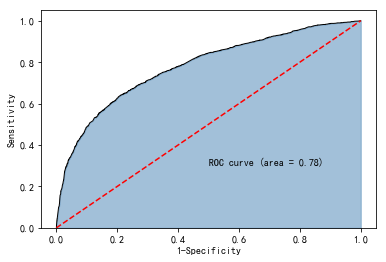

In [9]:
# 计算正例的预测概率，用于生成ROC曲线的数据
y_score = AdaBoost2.predict_proba(X_test[predictors])[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr, tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw=1)
# 添加对角线
plt.plot([0,1], [0,1], color='red', linestyle='--')
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

In [10]:
# 运用网格搜索法选择梯度提升树的合理参数组合
learning_rate = [0.01, 0.05, 0.1, 0.2]
n_estimators = [100, 300, 500]
max_depth = [3, 4, 5, 6]
params = {'learning_rate':learning_rate, 'n_estimators':n_estimators, 'max_depth':max_depth}
gbdt_grid = GridSearchCV(estimator=ensemble.GradientBoostingClassifier(), 
                         param_grid=params, scoring='roc_auc', cv=5, n_jobs=4, verbose=1)
gbdt_grid.fit(X_train[predictors], y_train)
# 返回参数的最佳组合和对应AUC值
gbdt_grid.best_params_, gbdt_grid.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 14.5min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 18.9min finished


({'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100},
 0.7739104313607261)

In [11]:
# 基于最佳参数组合的GBDT模型，对测试数据集进行预测
pred = gbdt_grid.predict(X_test[predictors])
# 返回模型的预测效果
print('模型的准确率为：\n',metrics.accuracy_score(y_test, pred))
print('模型的评估报告：\n',metrics.classification_report(y_test, pred))

模型的准确率为：
 0.8144
模型的评估报告：
              precision    recall  f1-score   support

          0       0.83      0.95      0.89      5800
          1       0.68      0.35      0.46      1700

avg / total       0.80      0.81      0.79      7500



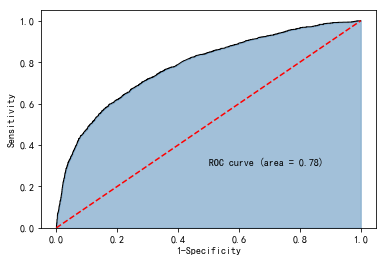

In [12]:
# 计算违约客户的概率值，用于生成ROC曲线的数据
y_score = gbdt_grid.predict_proba(X_test[predictors])[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw=1)
# 添加对角线
plt.plot([0,1], [0,1], color='red', linestyle='--')
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

In [7]:
# 读入数据
creditcard = pd.read_csv(r'creditcard.csv')

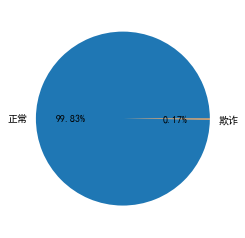

In [8]:
# 为确保绘制的饼图为圆形，需执行如下代码
plt.axes(aspect = 'equal')
# 统计交易是否为欺诈的频数
counts = creditcard.Class.value_counts()
# 绘制饼图
plt.pie(x=counts,   # 绘图数据
        labels=pd.Series(counts.index).map({0:'正常', 1:'欺诈'}),   # 添加文字标签
        autopct='%.2f%%')   # 设置百分比的格式，这里保留一位小数
# 显示图形
plt.show()

In [11]:
# 将数据拆分为训练集和测试集
# 删除自变量中的Time变量
X = creditcard.drop(['Time', 'Class'], axis=1)
y = creditcard.Class
# 数据拆分
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1234)

In [12]:
# 导入第三方包
from imblearn.over_sampling import SMOTE

# 运用SMOTE算法实现训练数据集的平衡
over_samples = SMOTE(random_state=1234) 
# over_samples_X,over_samples_y = over_samples.fit_sample(X_train, y_train)
over_samples_X, over_samples_y = over_samples.fit_sample(X_train.values, y_train.values.ravel())
# 重抽样前的类别比例
print(y_train.value_counts()/len(y_train))
# 重抽样后的类别比例
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

0    0.998239
1    0.001761
Name: Class, dtype: float64
1    0.5
0    0.5
dtype: float64


In [14]:
# https://www.lfd.uci.edu/~gohlke/pythonlibs/
# 导入第三方包
import xgboost
import numpy as np
# 构建XGBoost分类器
xgboost = xgboost.XGBClassifier()
# 使用重抽样后的数据，对其建模
xgboost.fit(over_samples_X, over_samples_y)
# 将模型运用到测试数据集中
resample_pred = xgboost.predict(np.array(X_test))

# 返回模型的预测效果
print('模型的准确率为：\n', metrics.accuracy_score(y_test, resample_pred))
print('模型的评估报告：\n', metrics.classification_report(y_test, resample_pred))

模型的准确率为：
 0.9992977774656788
模型的评估报告：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.78      0.81      0.79       141

    accuracy                           1.00     85443
   macro avg       0.89      0.90      0.90     85443
weighted avg       1.00      1.00      1.00     85443



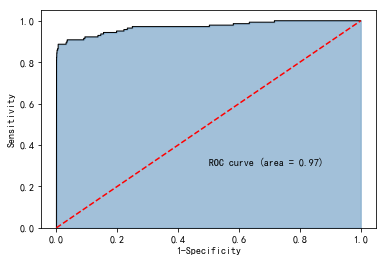

In [15]:
# 计算欺诈交易的概率值，用于生成ROC曲线的数据
y_score = xgboost.predict_proba(np.array(X_test))[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr, tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw=1)
# 添加对角线
plt.plot([0,1], [0,1], color='red', linestyle='--')
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

In [16]:
# 构建XGBoost分类器
import xgboost
xgboost2 = xgboost.XGBClassifier()
# 使用非平衡的训练数据集拟合模型
xgboost2.fit(X_train, y_train)
# 基于拟合的模型对测试数据集进行预测
pred2 = xgboost2.predict(X_test)
# 混淆矩阵
pd.crosstab(pred2,y_test)

Class,0,1
row_0,,
0,85292,32
1,10,109


In [17]:
# 返回模型的预测效果
print('模型的准确率为：\n', metrics.accuracy_score(y_test, pred2))
print('模型的评估报告：\n', metrics.classification_report(y_test, pred2))

模型的准确率为：
 0.9995084442259752
模型的评估报告：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.92      0.77      0.84       141

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



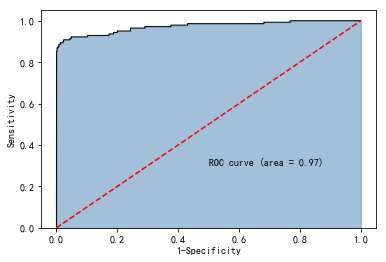

In [18]:
# 计算欺诈交易的概率值，用于生成ROC曲线的数据
y_score = xgboost2.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr, tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw=1)
# 添加对角线
plt.plot([0,1], [0,1], color='red', linestyle='--')
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()